In [51]:
import numpy as np
from lattice_class import *
from hamiltonian_constructor_class import *
import scipy.linalg
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

[(27, 28), (33, 34), (28, 29), (34, 35), (29, 30), (35, 36), (30, 31), (36, 37), (31, 32), (37, 38)] [(1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3)]


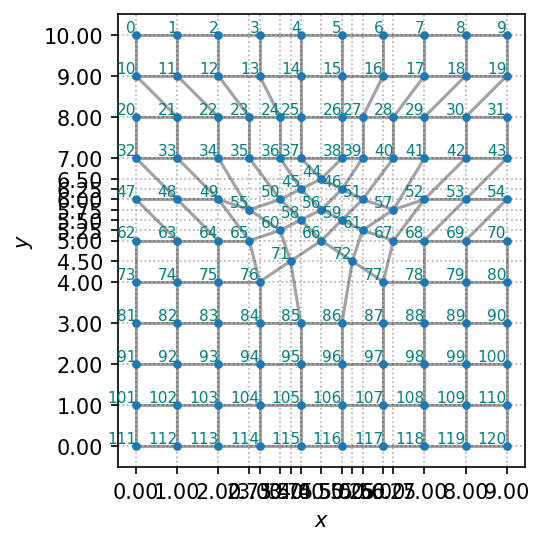

In [55]:
lattice = Lattice()
lattice.add_sites(
    [
        (0, 0),
        (1, 0),
        (2, 0),
        (3, 0),
        (0, 1),
        (1, 1),
        (2, 1),
        (3, 1),
        (0, 2),
        (0.75, 2.5),
        (1.5, 3),
        (2.25, 2.5),
        (3, 2),
        (-0.25, 3),
        (0.5, 3.25),
        (1, 3.5),
        (1.5, 3.75),
        (2, 3.5),
        (2.5, 3.25),
        (3.25, 3),
        (-0.25, 3 + 0.75),
        (0.5, 3.25 + 0.75),
        (1, 3.5 + 0.75),
        (1.5, 3.75 + 0.75),
        (2, 3.5 + 0.75),
        (2.5, 3.25 + 0.75),
        (3.25, 3 + 0.75),
        (-0.25, 3 + 1.25 + 0.75),
        (0.5, 3.25 + 1.0 + 0.75),
        (1, 3.5 + 0.75 + 0.75),
        (2, 3.5 + 0.75 + 0.75),
        (2.5, 3.25 + 1.0 + 0.75),
        (3.25, 3 + 1.25 + 0.75),
        (-0.25, 3 + 1.25 + 0.75 + 1.0),
        (0.5, 3.25 + 1.0 + 0.75 + 1.0),
        (1, 3.5 + 0.75 + 0.75 + 1.0),
        (2, 3.5 + 0.75 + 0.75 + 1.0),
        (2.5, 3.25 + 1.0 + 0.75 + 1.0),
        (3.25, 3 + 1.25 + 0.75 + 1.0),
    ]
)

lattice.add_bonds(
    [(j + i * 4, j + 1 + i * 4) for j in range(3) for i in range(2)],
    [(1, 3) for i in range(6)],
)
# lattice.add_bonds([(4+i, 4+i+1) for i in range(3)])
lattice.add_bonds(
    [(2 * 4 + j, 2 * 4 + j + 1) for j in range(4)], [(1, 3) for i in range(4)]
)
lattice.add_bonds(
    [
        (2 * 4 + 5 + j + i * 7, 2 * 4 + 5 + j + 1 + i * 7)
        for j in range(6)
        for i in range(2)
    ],
    [(1, 3) for i in range(12)],
)
print(
    [
        (2 * 4 + 5 + 2 * 7 + j + i * 6, 2 * 4 + 5 + 2 * 7 + j + 1 + i * 6)
        for j in range(5)
        for i in range(2)
    ],
    [(1, 3) for i in range(10)],
)
lattice.add_bonds(
    [
        (2 * 4 + 5 + 2 * 7 + j + i * 6, 2 * 4 + 5 + 2 * 7 + j + 1 + i * 6)
        for j in range(5)
        for i in range(2)
    ],
    [(1, 3) for i in range(10)],
)

lattice.add_bonds([(0, 4), (5, 1), (6, 2), (7, 3)], [(0, 2) for i in range(4)])
lattice.add_bonds([(4, 8), (5, 9), (6, 11), (7, 12)], [(0, 2) for i in range(4)])
lattice.add_bonds(
    [(8, 13), (9, 14), (10, 15), (10, 17), (11, 18), (12, 19)],
    [(0, 2) for i in range(6)],
)
lattice.add_bonds(
    [(14, 20), (15, 21), (16, 22), (16, 24), (17, 25), (18, 26)],
    [(0, 2) for i in range(6)],
)
lattice.add_bonds(
    [(21, 27), (22, 28), (23, 29), (23, 30), (24, 31), (25, 32)],
    [(0, 2) for i in range(6)],
)
lattice.add_bonds([(27 + j, 33 + j) for j in range(6)], [(0, 2) for i in range(6)])


# lattice.remove_sites([38, 32, 26, 19])
# lattice.add_sites([(-1, i) for i in range(3)])


# lattice.add_bonds([(35, 0), (36, 4), (37, 8), (3, 35), (7, 36), (12, 37), (18, 13), (18, 19), (24, 19), (12, 13), (29, 25), (34, 30), (24, 25)], [(1, 3) for i in range(13)])
# lattice.add_bonds([(35, 36), (36, 37), (30, 35), (31, 0), (32, 1), (33, 2), (34, 3)], [(0, 2) for i in range(7)])

# lattice.plot(True)

lattice.move_lattice((3.0, 2.0))
lattice.add_sites([(j, 2.0 + i) for i in range(0, 7) for j in range(3)])
lattice.add_sites([(7.0 + j, 2.0 + i) for i in range(0, 7) for j in range(3)])
lattice.add_sites([(j, i) for i in range(2) for j in range(10)])
lattice.add_sites([(j, 9 + i) for i in range(2) for j in range(10)])

# lattice.plot(True)

lattice.canonical_order()
# lattice.plot(True)

lattice.add_bonds(
    [(i * 10 + j, i * 10 + j + 1) for i in range(2) for j in range(9)],
    [(1, 3) for i in range(2) for j in range(9)],
)
lattice.add_bonds(
    [(i * 10 + j, (i + 1) * 10 + j + i) for i in range(2) for j in range(10)],
    [(0, 2) for i in range(2) for j in range(10)],
)
lattice.add_bonds(
    [(i * 10 + j + 1, i * 10 + j + 1 + 1) for i in range(10, 12) for j in range(9)],
    [(1, 3) for i in range(10, 12) for j in range(9)],
)
lattice.add_bonds(
    [((i - 1) * 10 + j + 1, i * 10 + j + 1) for i in range(10, 12) for j in range(10)],
    [(0, 2) for i in range(10, 12) for j in range(10)],
)

lattice.add_bonds(
    [
        (91, 81),
        (81, 73),
        (73, 62),
        (92, 82),
        (82, 74),
        (74, 63),
        (63, 47),
        (93, 83),
        (83, 75),
        (75, 64),
        (64, 48),
        (48, 32),
        (65, 49),
        (49, 33),
        (55, 34),
        (32, 20),
        (33, 21),
        (34, 22),
    ],
    [(0, 2) for i in range(18)],
)
lattice.add_bonds(
    [
        (94, 93),
        (93, 92),
        (92, 91),
        (84, 83),
        (83, 82),
        (82, 81),
        (76, 75),
        (75, 74),
        (74, 73),
        (65, 64),
        (64, 63),
        (63, 62),
        (55, 49),
        (49, 48),
        (48, 47),
        (35, 34),
        (34, 33),
        (33, 32),
        (23, 22),
        (22, 21),
        (21, 20),
    ],
    [(3, 1) for i in range(21)],
)

lattice.add_bonds(
    [
        (98, 88),
        (88, 78),
        (78, 68),
        (68, 53),
        (53, 43),
        (99, 89),
        (89, 79),
        (79, 69),
        (69, 54),
        (100, 90),
        (90, 80),
        (80, 70),
        (57, 41),
        (41, 29),
        (67, 52),
        (52, 42),
        (42, 30),
        (43, 31),
    ],
    [(0, 2) for i in range(18)],
)
lattice.add_bonds(
    [
        (97, 98),
        (98, 99),
        (99, 100),
        (87, 88),
        (88, 89),
        (89, 90),
        (77, 78),
        (78, 79),
        (79, 80),
        (67, 68),
        (68, 69),
        (69, 70),
        (57, 52),
        (52, 53),
        (53, 54),
        (40, 41),
        (41, 42),
        (42, 43),
        (28, 29),
        (29, 30),
        (30, 31),
    ],
    [(1, 3) for i in range(21)],
)
lattice.canonical_order()
lattice.plot(True)


flagged_bonds_triangle = [(37, 44), (36, 45), (35, 50), (34, 55), (33, 49), (32, 48)]
flagged_bonds_pentagon = [(71, 85), (76, 84), (75, 83), (74, 82), (73, 81)]
num_sites = lattice.get_num_sites()
lattice_sites = lattice.get_sites()

[238 239 240 241 242 243 244 245]
Lowest found energy:  0.010899145308898805
Index of lowest absolute energy:  242


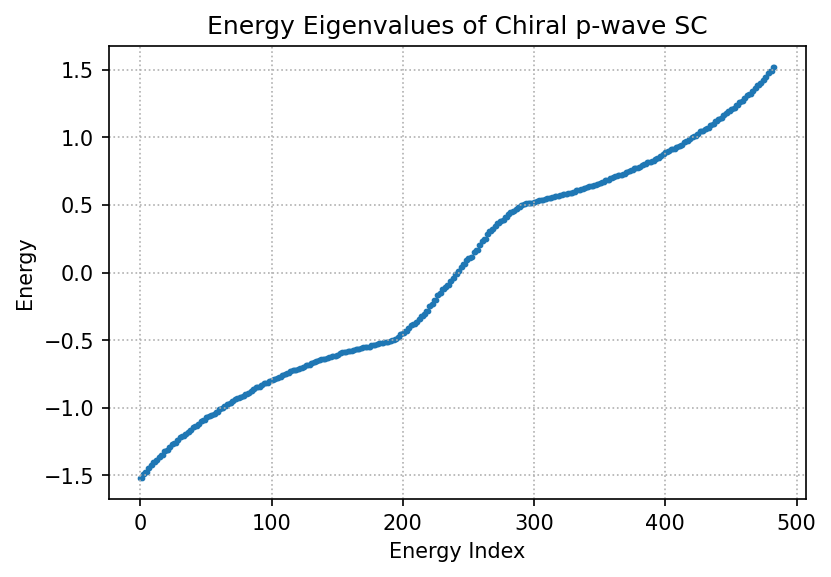

Index = 237 with energy E = -0.06334832857475882


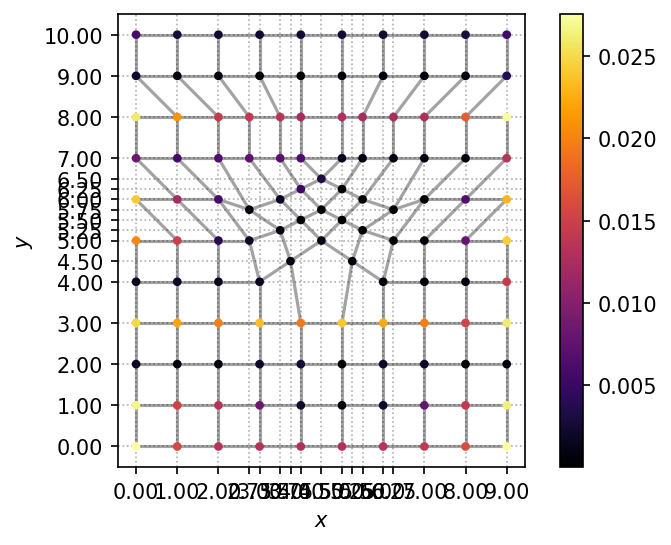

Index = 238 with energy E = -0.04063155794979064


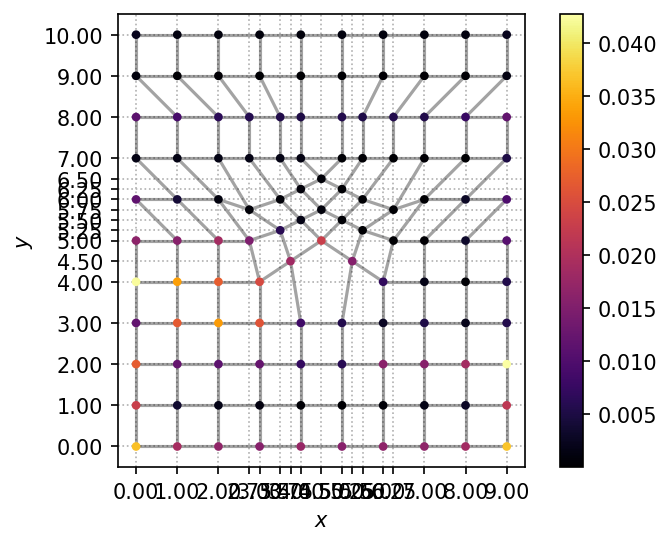

Index = 239 with energy E = -0.040631557949790044


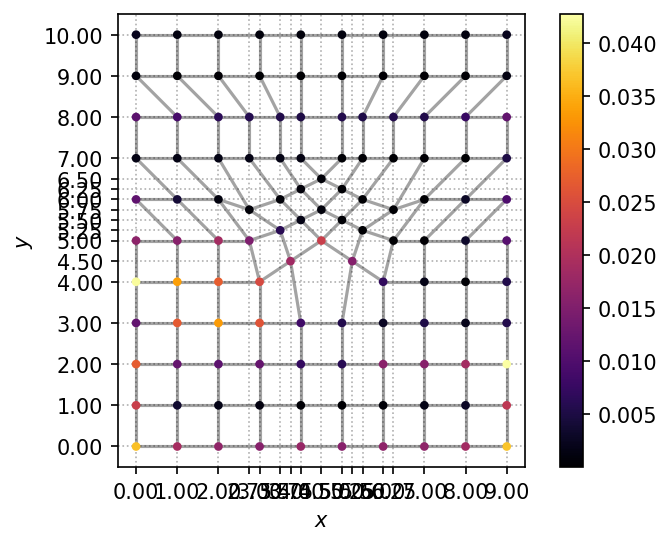

Index = 240 with energy E = -0.01089914530889943


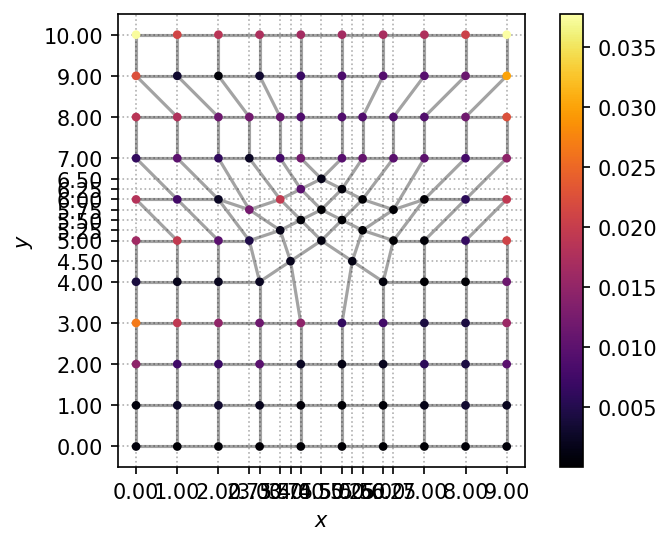

Index = 241 with energy E = -0.010899145308898881


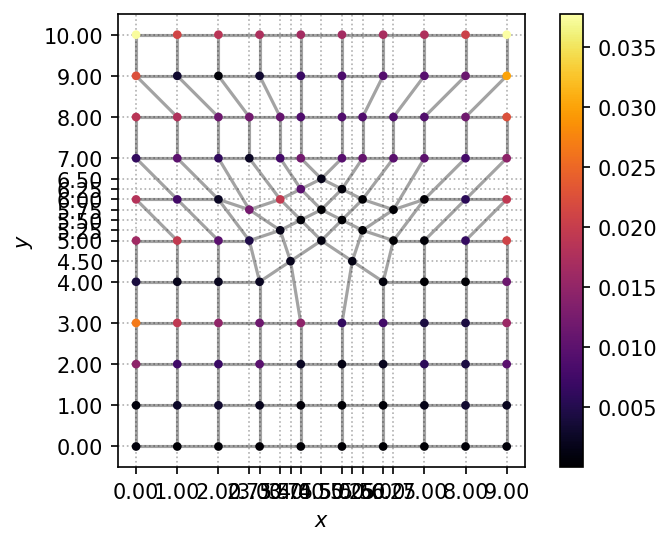

Index = 242 with energy E = 0.010899145308898805


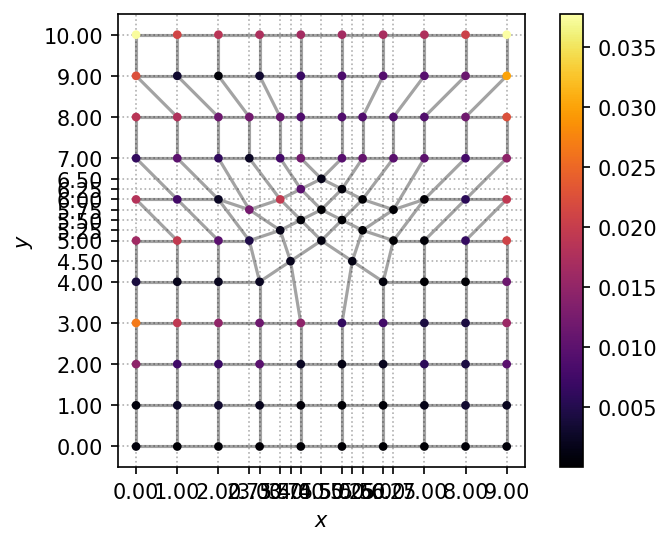

Index = 243 with energy E = 0.010899145308899192


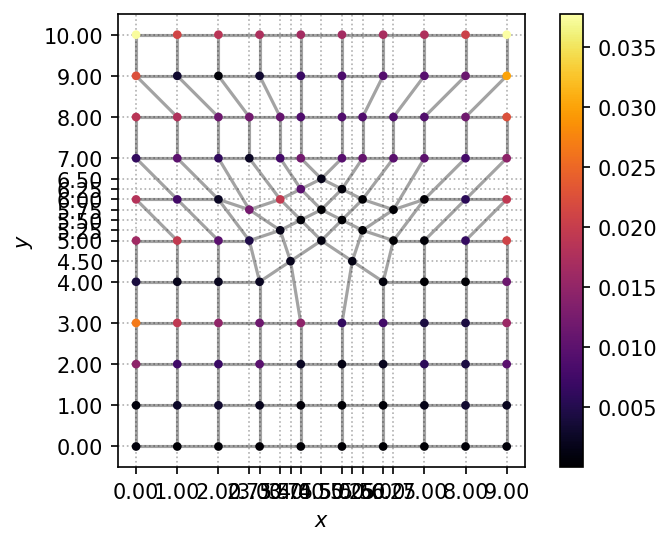

Index = 244 with energy E = 0.04063155794979009


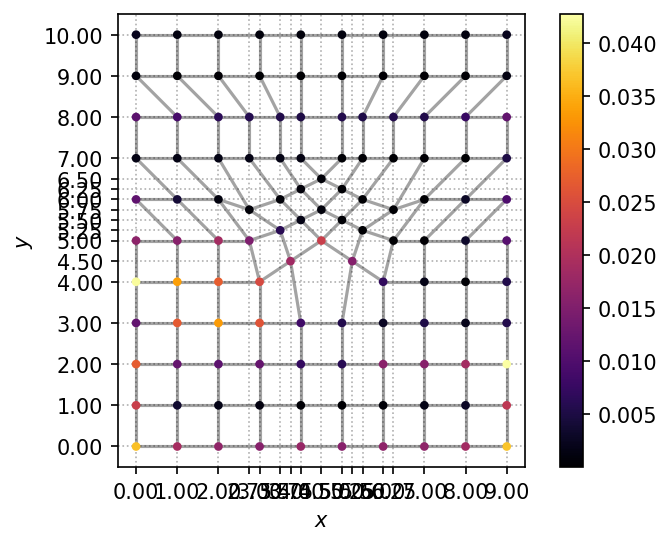

Index = 245 with energy E = 0.04063155794979032


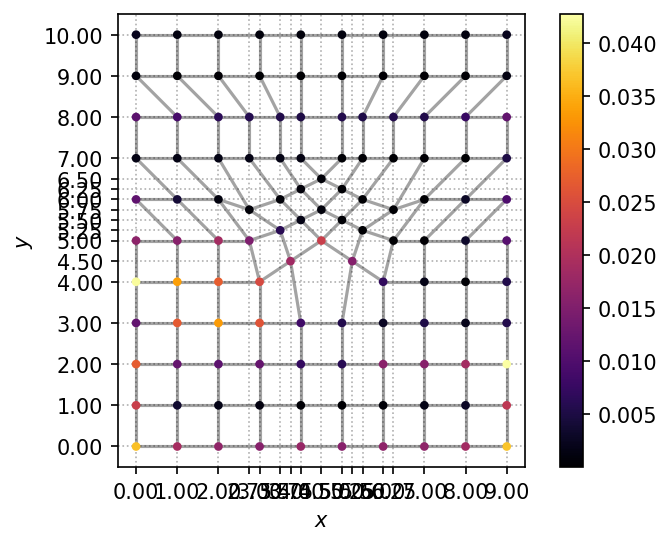

Index = 246 with energy E = 0.06334832857475864


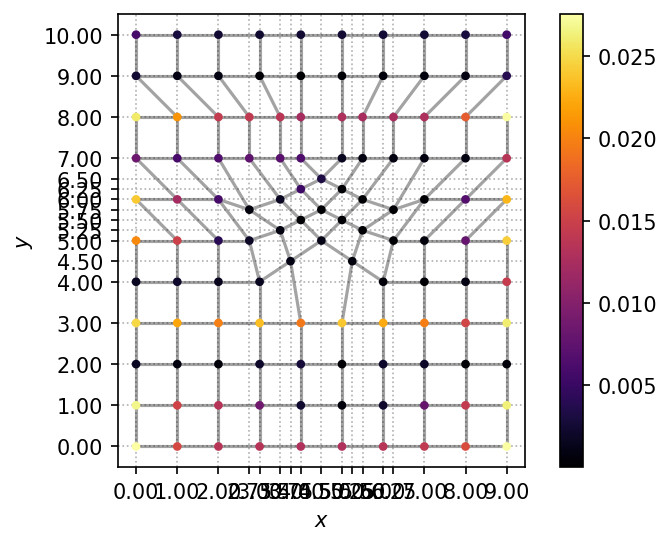

Index = 247 with energy E = 0.06334832857475879


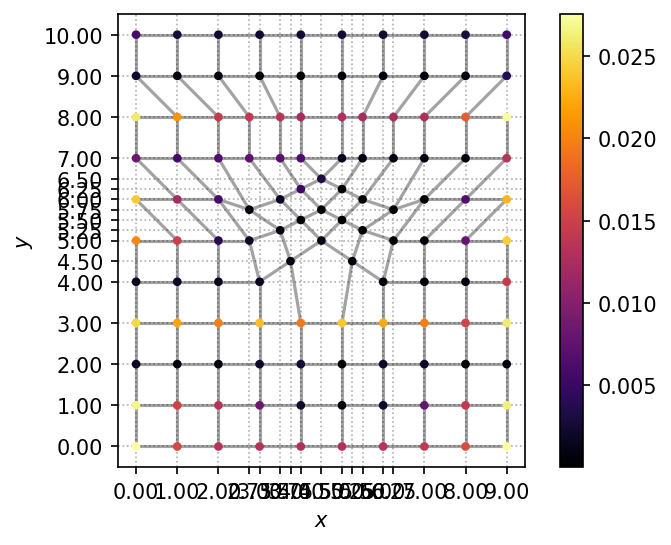

In [53]:
mu = 0.5
delta = complex(0.5, 0.0)

Ham_constructor = HamiltonianConstructor(mu, 0.5, 0.5, delta)
H_direct_lattice = Ham_constructor.construct_direct_lattice_hamiltonian(lattice)
block_indices = Ham_constructor.get_block_indices(lattice.get_num_sites())

hop_phase_triangle = np.exp(complex(0, 1) * np.pi / 2)

for flagged_bond in flagged_bonds_triangle:
    Ham_constructor.add_phase(
        H_direct_lattice, flagged_bond, hop_phase_triangle, num_sites
    )

hop_phase_pentagon = hop_phase_triangle.conjugate()
for flagged_bond in flagged_bonds_pentagon:
    Ham_constructor.add_phase(
        H_direct_lattice, flagged_bond, hop_phase_pentagon, num_sites
    )

energies, states = scipy.linalg.eigh(H_direct_lattice)

tol = 0.05
low_energy_indices = np.argwhere(np.abs(energies) < tol)[:, 0]
print(low_energy_indices)

print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)

plt.xlabel("Energy Index")
plt.ylabel("Energy")
plt.grid(linestyle=":")
plt.title("Energy Eigenvalues of Chiral p-wave SC")
plt.scatter(range(len(energies)), energies, s=3)
plt.show()

for gs_idx in range(gs_idx - 5, gs_idx + 6):
    print(f"Index = {gs_idx} with energy E = {energies[gs_idx]}")
    gs_wave_function = states[:, gs_idx]
    gs_probabilities_nambu = np.square(np.abs(gs_wave_function))
    gs_probabilities = np.zeros(shape=(num_sites, 1))

    for site_idx in range(num_sites):
        gs_probabilities[site_idx] = np.sum(
            gs_probabilities_nambu[block_indices[site_idx]]
        )

    x_values = [k[0] for k in lattice_sites]
    y_values = [k[1] for k in lattice_sites]

    color_map = plt.get_cmap("inferno")
    sc = lattice.plot(False, c=(gs_probabilities), cmap=color_map)
    plt.colorbar(sc)
    plt.show()